In [1]:
import os
from nilearn import datasets, plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Creating the diagnostic_label.csv, age.csv and sex.csv files from the patient_info.csv file
def extract_info_and_write_csv(patient_info_file):
    patient_info_df = pd.read_csv(patient_info_file)

    age_df = patient_info_df[['Age']]
    age_df.to_csv('ADNI_full/age.csv', index=False, header=False)

    sex_df = patient_info_df[['Sex']]
    sex_df.to_csv('ADNI_full/sex.csv', index=False, header=False)

    diagnostic_label_df = patient_info_df[['Research Group']]
    diagnostic_label_df.to_csv('ADNI_full/diagnostic_label.csv', index=False, header=False)

extract_info_and_write_csv('ADNI_full/patient_info.csv')

In [3]:
# Generating the brain atlas
atlas = datasets.fetch_atlas_aal()
atlas_filename = atlas.maps
labels = atlas.labels

# Finding the coordinates of the brain segments
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas.maps)

# Making a dictionary out of the positions of the brain segments and the positions in MNI space
brain_segments_pos = {}
for idx, val in enumerate(atlas.labels):
    brain_segments_pos[val] = list(np.around(coordinates[idx],2))

In [4]:
# Here I start with the ADNI_full folder with the time_series folder already generated, so I only need to load the time series
def load_time_series():
    root = 'ADNI_full/time_series'
    time_series_list = os.listdir(root)
    time_series=[]
    for i in time_series_list:
        time_series_sub = np.loadtxt(os.path.join(root, i), delimiter=',')
        time_series.append(time_series_sub)
    return time_series

In [5]:
# Make the list of time series into a list of df
def time_series_to_df(time_series):
    df_time_series = []
    for i in time_series:
        df = pd.DataFrame(i)
        df_time_series.append(df)
    return df_time_series

In [6]:
# Defining the different correlation relations to build the correlation matrix.
# We also set the NaN values to 0.

# Diag 1 ou 0

def pearson_corr(df_time_series):
    corr_matrices = []
    for df in df_time_series:
        corr_df = df.corr(method='pearson').fillna(0)
        corr_matrices.append(corr_df.to_numpy())
    return corr_matrices

def spearman_rank_corr(df_time_series):
    corr_matrices = []
    for df in df_time_series:
        corr_df = df.corr(method='spearman').fillna(0)
        corr_matrices.append(corr_df.to_numpy())
    return corr_matrices

def kendall_rank_corr(df_time_series):
    corr_matrices = []
    for df in df_time_series:
        corr_df = df.corr(method='kendall').fillna(0)
        corr_matrices.append(corr_df.to_numpy())
    return corr_matrices

def partial_corr(df_time_series):
    corr_matrices = []
    for df in df_time_series:
        corr_df = df.corr(method='pearson').fillna(0)
        n = corr_df.shape[0]
        partial_corr_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                partial_corr_matrix[i, j] = -corr_df.iloc[i, j] / np.sqrt(corr_df.iloc[i, i] * corr_df.iloc[j, j])
        corr_matrices.append(partial_corr_matrix)
    return corr_matrices

In [7]:
# Plot the correlation matrix
def plot_corr(corr_matrix, method):
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr_matrix, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(f'{method} Correlation Matrix')
    plt.show()

In [8]:
# Loading the time_series and building the df of time_series
time_series = load_time_series()
df_time_series = time_series_to_df(time_series)

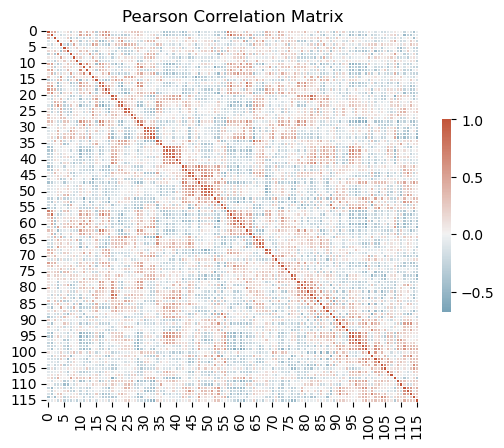

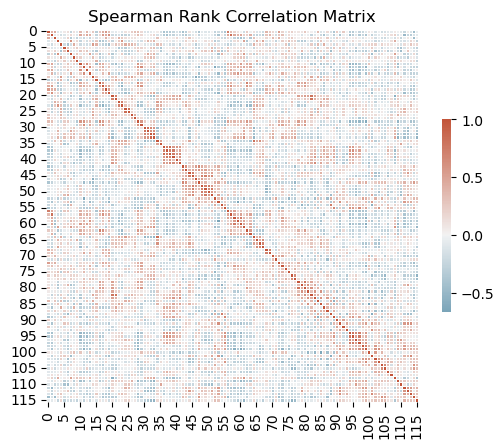

In [9]:
# Generating the correlation matrices
idx_patient = 20

# Using the pearson correlation function
corr_matrix_pearson = pearson_corr(df_time_series)
plot_corr(corr_matrix_pearson[idx_patient], 'Pearson')

# Using the spearman rank correlation function
corr_matrix_spearman = spearman_rank_corr(df_time_series)
plot_corr(corr_matrix_spearman[idx_patient], 'Spearman Rank')

# Using the kendall rank correlation function
corr_matrix_kendall = kendall_rank_corr(df_time_series)
plot_corr(corr_matrix_kendall[idx_patient], 'Kendall Rank')

# Using the partial correlation function
corr_matrix_partial = partial_corr(df_time_series)
plot_corr(corr_matrix_partial[idx_patient], 'Partial')

In [ ]:
# Compare the differences between all the matrices. Here I am using the Frobenius norm to measure the element-wise differences.

matrices = [corr_matrix_pearson[idx_patient], corr_matrix_spearman[idx_patient], corr_matrix_kendall[idx_patient], corr_matrix_partial[idx_patient]]

def compare_correlation_matrices(matrices):
    num_matrices = len(matrices)
    dissimilarities = np.zeros((num_matrices, num_matrices))
    for i in range(num_matrices):
        for j in range(i+1, num_matrices):
            diff_matrix = matrices[i] - matrices[j]
            frobenius_norm = np.linalg.norm(diff_matrix, ord='fro')
            dissimilarities[i, j] = frobenius_norm
            dissimilarities[j, i] = frobenius_norm
    return dissimilarities

# Compare matrices
dissimilarities = compare_correlation_matrices(matrices)
print("Dissimilarities between correlation matrices:")
print(dissimilarities)

Dissimilarities between correlation matrices:
[[ 0.          4.0157538   9.97899635 59.66027668]
 [ 4.0157538   0.          8.3128964  58.44870101]
 [ 9.97899635  8.3128964   0.         50.87390177]
 [59.66027668 58.44870101 50.87390177  0.        ]]


In [ ]:
# Saving all the Correlation Matrices
def save_matrix(corr_matrix, method):
    directory = f'ADNI_full/corr_matrices/corr_matrix_{method}/'
    patient_info = pd.read_csv('ADNI_full/patient_info.csv')
    os.makedirs(directory, exist_ok=True)
    for idx_patient, name_patient in enumerate(patient_info['Subject ID'].values):
        np.savetxt(f'{directory}patient_{name_patient}.csv', corr_matrix[idx_patient], delimiter=',')
    return None

save_matrix(corr_matrix_pearson, 'pearson')
save_matrix(corr_matrix_spearman, 'spearman')
save_matrix(corr_matrix_kendall, 'kendall')
save_matrix(corr_matrix_partial, 'partial')

In [ ]:
# Creating the dataframe with the time series, the correlation matrices and the diagnostic label for each patient
def create_df(time_series, corr_matrix_methods_list, corr_matrix_methods_names, patient_info):
    df = pd.DataFrame()
    df['Patient_id'] = patient_info['Subject ID']
    df['Age'] = patient_info['Age']
    df['Sex'] = patient_info['Sex']
    df['Time_series'] = time_series
    for i in range(len(corr_matrix_methods_list)):
        corr_matrix = corr_matrix_methods_list[i]
        method = corr_matrix_methods_names[i]
        df[f'Corr_matrix_{method}'] = corr_matrix
    df['Diagnostic_label'] = patient_info['Research Group']
    return df

# Loading the diagnostic label
patient_info = pd.read_csv('ADNI_full/patient_info.csv')
corr_matrix_methods_list = [corr_matrix_pearson, corr_matrix_spearman , corr_matrix_kendall, corr_matrix_partial]
corr_matrix_methods_names = ['pearson', 'spearman', 'kendall', 'partial']
full_df = create_df(df_time_series, corr_matrix_methods_list, corr_matrix_methods_names, patient_info)

Headers of the dataframe: 
 Patient_id, Age, Sex, Time_series, Corr_matrix_pearson, Corr_matrix_spearman, Corr_matrix_kendall, Corr_matrix_partial, Diagnostic_label 

First 5 rows of the dataframe: 
    Patient_id   Age Sex                                        Time_series  \
0  002_S_0295  90.0   M            0         1         2         3     ...   
1  002_S_0413  81.5   F            0         1         2         3     ...   
2  002_S_0685  94.7   F            0         1         2         3     ...   
3  002_S_0729  70.3   F            0         1         2         3     ...   
4  002_S_1155  63.0   M            0         1         2         3     ...   

                                 Corr_matrix_pearson  \
0  [[1.0, 0.8056247552530764, 0.46635803030073997...   
1  [[1.0, 0.5790744332365937, 0.3135117294185946,...   
2  [[1.0, 0.6490690879701971, 0.14739383709840614...   
3  [[1.0, 0.5434989760459465, -0.0721394345432629...   
4  [[1.0, 0.6794114694061416, 0.4750765976841186,..

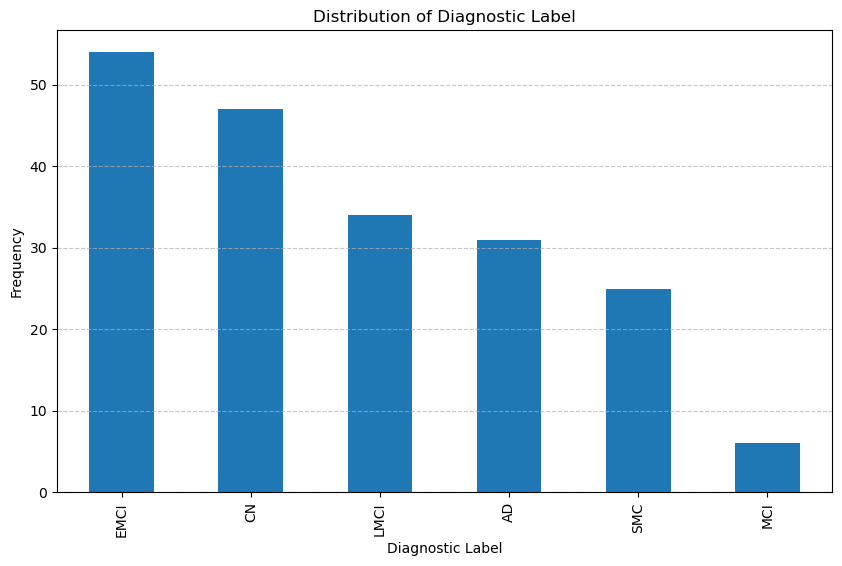

Distribution of the age of the patients (rounded): 
 Age
74.0    18
75.0    13
72.0    13
70.0    11
79.0    11
69.0    11
68.0    10
73.0     9
77.0     9
76.0     8
71.0     8
80.0     7
66.0     7
67.0     7
78.0     6
61.0     4
64.0     4
85.0     4
87.0     4
63.0     4
65.0     3
60.0     3
82.0     3
81.0     3
57.0     2
83.0     2
56.0     2
62.0     2
86.0     2
84.0     1
88.0     1
89.0     1
90.0     1
59.0     1
95.0     1
58.0     1
Name: count, dtype: int64 



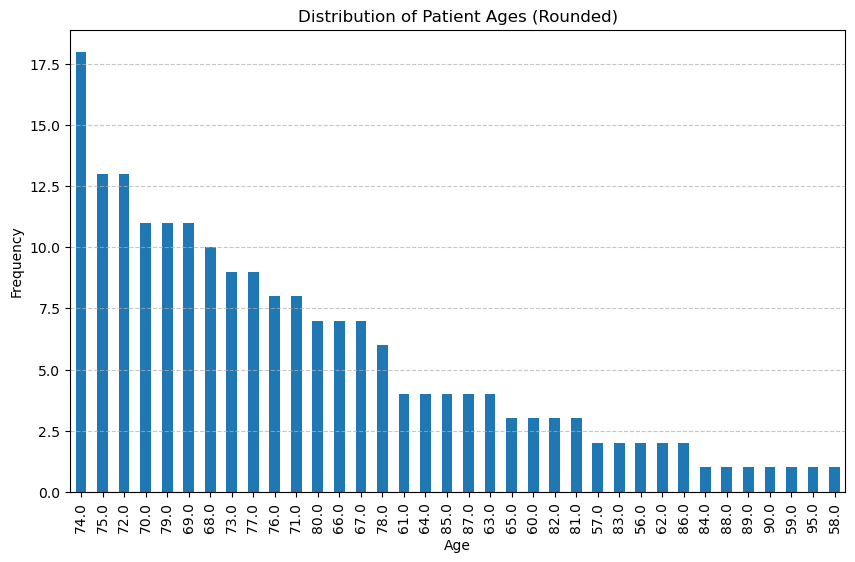

Distribution of the sex of the patients: 
 Sex
F    104
M     93
Name: count, dtype: int64 



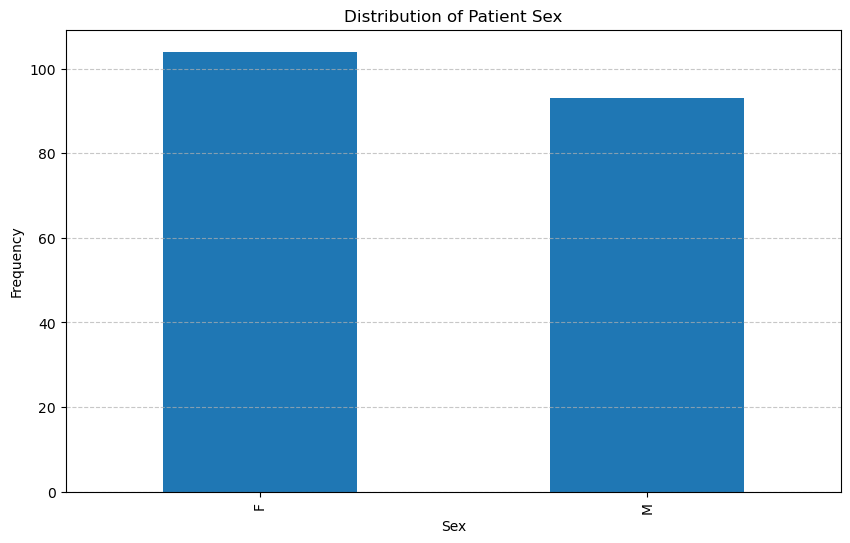

In [ ]:
# Visualizing a few features of the dataframe
print(f'Headers of the dataframe: \n', ', '.join(full_df.columns), '\n')
print(f'First 5 rows of the dataframe: \n', full_df.head(), '\n')
print(f'The shape of the dataframe: \n', full_df.shape, '\n')
print(f'The time series of the first patient: \n', full_df['Time_series'][0], '\n')
print(f'The number of patients: \n', full_df['Patient_id'], '\n')

# Visualizing the distribution of a few features in the dataframe
## Distribution of the diagnostic label
print(f'Distribution of the diagnostic label: \n', full_df['Diagnostic_label'].value_counts(), '\n')
plt.figure(figsize=(10, 6))
full_df['Diagnostic_label'].value_counts().plot(kind='bar')
plt.title("Distribution of Diagnostic Label")
plt.xlabel("Diagnostic Label")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
## Distribution of the age of the patients
rounded_age_distribution = full_df['Age'].round().value_counts()
print(f'Distribution of the age of the patients (rounded): \n', rounded_age_distribution, '\n')
plt.figure(figsize=(10, 6))
rounded_age_distribution.plot(kind='bar')
plt.title("Distribution of Patient Ages (Rounded)")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
## Distribution of the sex of the patients
print(f'Distribution of the sex of the patients: \n', full_df['Sex'].value_counts(), '\n')
plt.figure(figsize=(10, 6))
full_df['Sex'].value_counts().plot(kind='bar')
plt.title("Distribution of Patient Sex")
plt.xlabel("Sex")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


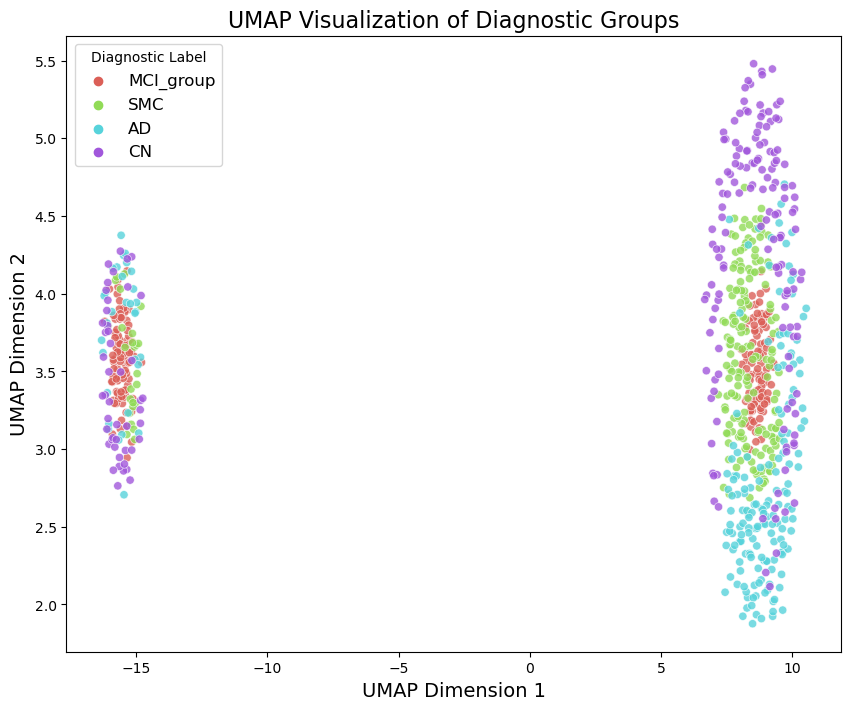

In [ ]:
# Exploring Umap to visualize the similarity between the MCI and SMC patients
## Code taken/inspired from: https://umap-learn.readthedocs.io/en/latest/basic_usage.html
import umap
from sklearn.preprocessing import StandardScaler

# Grouping LMCI, EMCI, and MCI patients together
full_df['Diagnostic_label'] = full_df['Diagnostic_label'].map(lambda x: 'MCI' if x in ['LMCI', 'EMCI', 'MCI'] else x)

# Comparing all the diagnostic labels (not wrt time series)

mci_data = full_df['Diagnostic_label'] == 'MCI'
smc_data = full_df['Diagnostic_label'] == 'SMC'
ad_data = full_df['Diagnostic_label'] == 'AD'
cn_data = full_df['Diagnostic_label'] == 'CN'

# Convert to numpy array and stack
mci_data_stacked = np.vstack(mci_data)
smc_data_stacked = np.vstack(smc_data)
ad_data_stacked = np.vstack(ad_data)
cn_data_stacked = np.vstack(cn_data)

# Concatenate data for all diagnostic labels
all_data = np.vstack((mci_data_stacked, smc_data_stacked, ad_data_stacked, cn_data_stacked))

# # Standardize the data
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(all_data)

# Perform UMAP dimensionality reduction
reducer = umap.UMAP()
embedding = reducer.fit_transform(all_data)

# Plot the UMAP embedding
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=["MCI_group"] * len(mci_data_stacked) + ["SMC"] * len(smc_data_stacked) +
        ["AD"] * len(ad_data_stacked) + ["CN"] * len(cn_data_stacked),
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.8
)

plt.title('UMAP Visualization of Diagnostic Groups', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.legend(title='Diagnostic Label', fontsize=12)
plt.show()



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


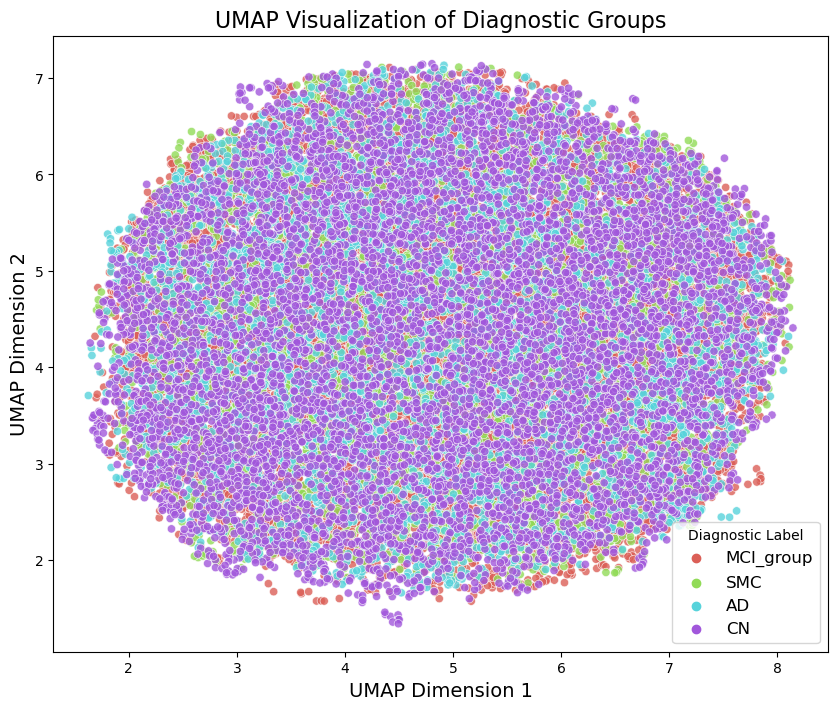

In [ ]:
# Comparing all the diagnostic labels (wrt time series)

mci_data = full_df[full_df['Diagnostic_label'] == 'MCI']['Time_series']
smc_data = full_df[full_df['Diagnostic_label'] == 'SMC']['Time_series']
ad_data = full_df[full_df['Diagnostic_label'] == 'AD']['Time_series']
cn_data = full_df[full_df['Diagnostic_label'] == 'CN']['Time_series']

# Convert to numpy array and stack
mci_data_stacked = np.vstack(mci_data)
smc_data_stacked = np.vstack(smc_data)
ad_data_stacked = np.vstack(ad_data)
cn_data_stacked = np.vstack(cn_data)

# Concatenate data for all diagnostic labels
all_data = np.vstack((mci_data_stacked, smc_data_stacked, ad_data_stacked, cn_data_stacked))

# # Standardize the data
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(all_data)

# Perform UMAP dimensionality reduction
reducer = umap.UMAP()
embedding = reducer.fit_transform(all_data)

# Plot the UMAP embedding
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=["MCI_group"] * len(mci_data_stacked) + ["SMC"] * len(smc_data_stacked) +
        ["AD"] * len(ad_data_stacked) + ["CN"] * len(cn_data_stacked),
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.8
)

plt.title('UMAP Visualization of Diagnostic Groups', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.legend(title='Diagnostic Label', fontsize=12)
plt.show()



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/wh/snjqmpvj7qv64q1ngy8zvqbh0000gn/T/ipykernel_96868/2949403132.py:23: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


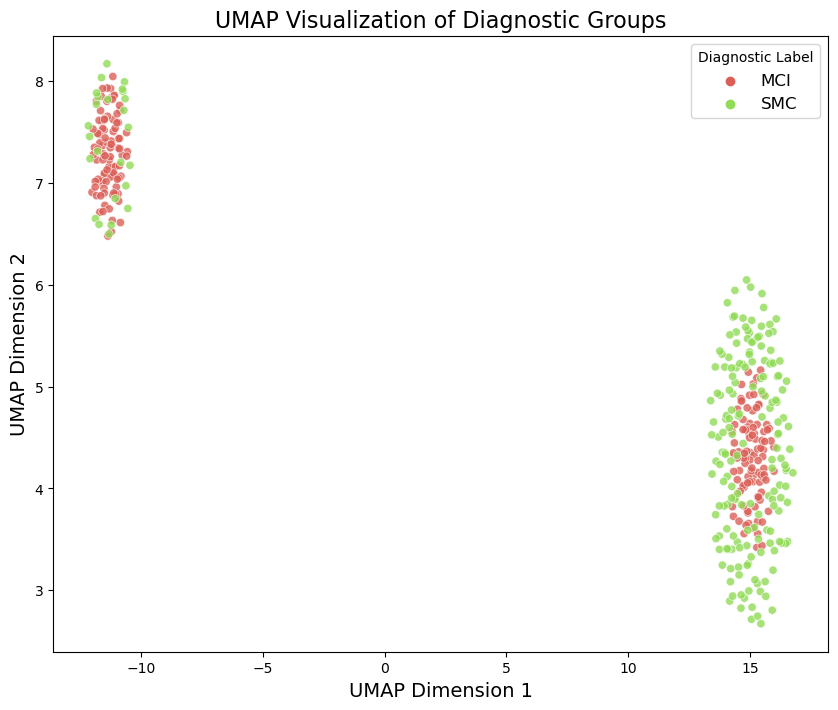

In [ ]:
# Comparing only the MCI and SMC patients (not wrt time series)

mci_data = full_df['Diagnostic_label'] == 'MCI'
smc_data = full_df['Diagnostic_label'] == 'SMC'

# Convert to numpy array and stack
mci_data_stacked = np.vstack(mci_data)
smc_data_stacked = np.vstack(smc_data)

# Concatenate data for all diagnostic labels
all_data = np.vstack((mci_data_stacked, smc_data_stacked))

# # Standardize the data
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(all_data)

# Perform UMAP dimensionality reduction
reducer = umap.UMAP()
embedding = reducer.fit_transform(all_data)

# Plot the UMAP embedding
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=["MCI"] * len(mci_data_stacked) + ["SMC"] * len(smc_data_stacked),
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.8
)
plt.title('UMAP Visualization of Diagnostic Groups', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.legend(title='Diagnostic Label', fontsize=12)
plt.show()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/wh/snjqmpvj7qv64q1ngy8zvqbh0000gn/T/ipykernel_96868/2692127073.py:23: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


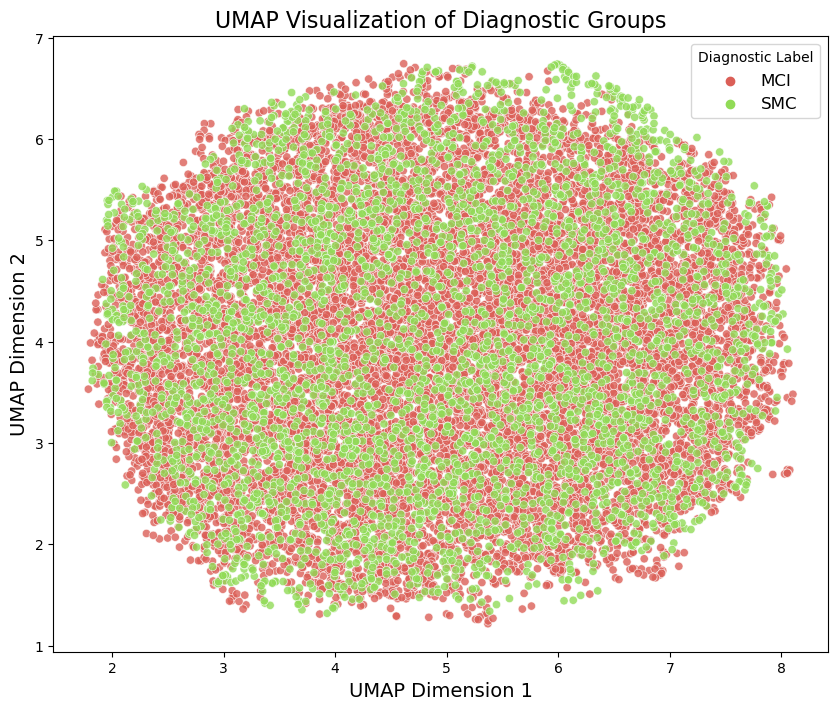

In [ ]:
# Comparing only the MCI and SMC patients (wrt time series)

mci_data = full_df[full_df['Diagnostic_label'] == 'MCI']['Time_series']
smc_data = full_df[full_df['Diagnostic_label'] == 'SMC']['Time_series']

# Convert to numpy array and stack
mci_data_stacked = np.vstack(mci_data)
smc_data_stacked = np.vstack(smc_data)

# Concatenate data for all diagnostic labels
all_data = np.vstack((mci_data_stacked, smc_data_stacked))

# # Standardize the data
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(all_data)

# Perform UMAP dimensionality reduction
reducer = umap.UMAP()
embedding = reducer.fit_transform(all_data)

# Plot the UMAP embedding
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=["MCI"] * len(mci_data_stacked) + ["SMC"] * len(smc_data_stacked),
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.8
)
plt.title('UMAP Visualization of Diagnostic Groups', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.legend(title='Diagnostic Label', fontsize=12)
plt.show()
